> 데이터 분석 계획  
1) 데이터 확인하기  
2) 처리하기 적절한 형태로 데이터 가공  
3) 모델링  
4) 피드백 

## 1) 데이터 확인 결과(test_simplified.csv, train_simplified)
### 방법 :  
23G에 달하는 대용량 data를 처리하기 위해 dask 패키지를 사용  
### 결과 :   
test data의 column name) **'key_id  ', 'countrycode', 'drawing'**  
train data의 column name) **'countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word'**

train data는 category 별로 data가 각각의 csv 파일로 구성되어 있으며 최소 10만개 최대 30만개까지의 데이터를 포함한다.  
나라의 문화에 따라 그림을 그리는 방식이나 그림의 모양새가 다를 것이라 추측했지만,  
나라마다 일정 개수씩 수집된 것이 아니므로 특정 국가에 데이터가 편중된 것을 볼 수 있었다.  
따라서, `countrycode를 고려하는 것은 무의미` 하다고 판단하였다.  

dask 패키지를 이용하여 train data로 가상 data frame을 형성하였다.  
이렇게 형성된 데이터에서 drawing과 word 열만 취하고 다시 random sampling 으로 일부 data만 가져왔다.  
그런 다음, 6:2:2 의 비율로 train,valid, test data를 나누어 주었다.  

## 2) 처리하기 적절한 형태로 데이터 가공
### 방법 :  
drawing data가 string type으로 제공되었다.  
하나의 stroke가 [x좌표의 sequce, y좌표의 squence]로 구성되어 있고, 이 stroke 들이 모여 하나의 그림을 만들어 낸다.  
주어진 word에 따라 그림을 그리는 동안 AI가 정답을 맞출 수 있어야 하므로 필요한 data는 x와 y 좌표쌍 그리고 획(stroke)의 시작과 끝점이다.  
주어진 drawing data에 json_loads를 적용시켜 list type으로 바꾸어 준 후, numpy의 stack 등을 이용하여 좌표쌍으로 구성한다.  

## 3) 모델링
### 방법 :  
획들이 모여 하나의 그림이 된다. 이전에 그은 획의 위치가 달라지면 당연히 그림도 달라진다.  
따라서, 이전에 그었던 획 정보들을 종합하여 그림이 속한 카테고리를 알아낼 수 있을 것이다.  
과거의 정보를 반영하기 위해 다음과 같은 구조로 **Reccurent Neural Network(RNN)** 모델을 구성할 것이다. 
![rnn-model](https://www.tensorflow.org/images/quickdraw_model.png)

먼저, 1D-convolution 을 적용시켜 feature를 풍부하게 하고  
두 단계의 LSTM networks를 거친 후 340개의 category로 분류될 수 있도록 softmax 함수를 적용시켰다.  

> import module

In [2]:
import os
from glob import glob # class별로 나뉘어 있는 train data를 받아오기 위해 glob module 을 사용
import pandas as pd
import numpy as np
import dask.dataframe as dd # 대용량 파일을 읽기위한 패키지
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plot
import json 

pbar = ProgressBar()
pbar.register()

print(os.listdir("../input"))

['sample_submission.csv', 'test_simplified.csv', 'test_raw.csv', 'train_simplified']


In [3]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import keras 
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential


Using TensorFlow backend.


## 데이터 불러오기

In [4]:
base_dir = os.path.join('..','input')
test_path = os.path.join(base_dir,'test_simplified.csv')
train_paths = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
# class별로 나뉘어있는 train data를 받아오기 위해 glob module 을 사용

test_data = pd.read_csv(test_path)
print("test_data columns: ",test_data.columns)
train_data = pd.read_csv(train_paths[0])
print("train_data columns: ",train_data.columns)
print("draw data type: ", type(train_data['drawing'][0]))

test_data columns:  Index(['key_id', 'countrycode', 'drawing'], dtype='object')
train_data columns:  Index(['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word'], dtype='object')
draw data type:  <class 'str'>


In [5]:
train_data.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,GB,"[[[0, 52, 79, 95, 119, 154, 175, 232, 253, 254...",5308841862365184,True,2017-03-16 08:17:09.868490,leaf
1,PK,"[[[56, 56], [67, 67]], [[49, 51, 44, 44, 48, 4...",6346088359395328,True,2017-03-15 20:27:48.393710,leaf
2,US,"[[[0, 60, 124], [255, 162, 92]], [[33, 57, 87,...",5804594418417664,False,2017-03-01 21:03:23.722220,leaf
3,AE,"[[[0, 47, 105], [167, 103, 60]], [[85, 81, 81,...",5531143698907136,True,2017-03-29 18:43:11.841340,leaf
4,CA,"[[[103, 107], [255, 177]], [[112, 103, 83, 33]...",6632150193405952,True,2017-03-01 00:22:10.294980,leaf


## drawing data-> (x,y,시작or끝)으로 데이터 가공  
궁금한 점 : stroke 마다 점의 수가 다른데 padding 해주어야 할까 ? 
=> 해주어야 한다. 길이가 일정한 입력을 만들어주기 위해서 

In [6]:
# drawing data를 [number of points,3] 크기의 tensor로 바꾸어주는 함수
def make_stroke2tensor(raw_strokes):
    # string type의 drawing data를 list로 변환
    stroke_lst = json.loads(raw_strokes)
    # storke_lst = (coord_x list,coor_y list) 들로 구성
    # -> 쌍이 되는 (x,y,stroke id)들로 이루어진 list를 만듦
    stroke_coords = [(x,y,i) for i,(x_lst,y_lst) in enumerate(stroke_lst) 
                  for x,y in zip(x_lst,y_lst)]
    # (x,y,index)들의 리스트인 그림 데이터 하나를 원소로 가지는 리스트로 구성
    stroke_coords = np.stack(stroke_coords)
    
    # 획의 시작과 끝의 정보 저장 
    stroke_coords[:,2] = [1]+np.diff(stroke_coords[:,2]).tolist()
    stroke_coords[:,2] += 1
    
    # return stroke_coords
    
    return pad_sequences(stroke_coords.swapaxes(0, 1), 
                         maxlen=200, 
                         padding='post').swapaxes(0, 1)

train_data.drawing = train_data.drawing.map(make_stroke2tensor)


In [7]:
# 임의의 train data file 을 살펴보니, train_data의 shape은 약 12만개의 데이터가 6개의 정보를 담고 있는 형태이고,
# drawing data는 1000개의 점으로 이루어진 data이다.
print(train_data.shape)
print(train_data.drawing.shape)
print(train_data.drawing[0].shape)

(125571, 6)
(125571,)
(200, 3)


In [8]:
X = np.stack(train_data.drawing,0)
Y = train_data.drawing
Y = np.stack(Y,0)
print(Y)

[[[  0 203   2]
  [ 52 170   1]
  [ 79  82   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 56  67   2]
  [ 56  67   1]
  [ 49 255   2]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0 255   2]
  [ 60 162   1]
  [124  92   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0 252   2]
  [ 14 229   1]
  [ 26 218   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 82 249   2]
  [ 82 195   1]
  [ 89   0   2]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 45   8   2]
  [ 16  47   1]
  [  1  86   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


In [9]:
X.shape
Y.shape

(125571, 200, 3)

In [10]:
# train_data.drawing # [[drawing data 나열:[x,y,startORend_info]]]

## data 구성하기

In [11]:
whole_train_data = dd.read_csv(train_paths)

In [12]:
# whole_train_data.count().compute()

In [13]:
a = whole_train_data[['drawing','word']].sample(frac = 0.008)

In [14]:
train_data,valid_data,train_test_data =a. random_split([0.60,0.20,0.20])

In [15]:
train_data.drawing.head()

[########################################] | 100% Completed |  0.8s


43216    [[[0, 48, 86], [131, 117, 99]], [[87, 85, 87, ...
99217    [[[39, 25, 21, 16, 1, 1, 11, 24, 56, 100, 104,...
28874    [[[69, 47, 25, 15, 15, 28, 60, 65, 90, 100, 10...
36172    [[[173, 109, 63, 49, 54], [255, 202, 136, 85, ...
63635    [[[53, 54, 49], [221, 255, 226]], [[58, 29, 13...
Name: drawing, dtype: object

In [16]:
train_word = train_data['word']
train_drawing = train_data.drawing
train_drawing = train_drawing.map(make_stroke2tensor,meta=('drawing', int))

valid_word = valid_data['word']
valid_drawing = valid_data.drawing
valid_drawing = valid_drawing.map(make_stroke2tensor,meta=('drawing', int))

train_test_word = train_test_data['word']
train_test_drawing = train_test_data.drawing
train_test_drawing = train_test_drawing.map(make_stroke2tensor,meta=('drawing',int))


In [17]:
# word 형태의 category를 one-hot encoding으로 분류하기 위함 
word_encoder = LabelEncoder()
word_encoder.fit(train_word)

train_word = to_categorical(word_encoder.transform(train_word.values))
valid_word = to_categorical(word_encoder.transform(valid_word.values))
train_test_word = to_categorical(word_encoder.transform(train_test_word.values))



[########################################] | 100% Completed |  5min 22.2s
[########################################] | 100% Completed |  5min 19.4s
[########################################] | 100% Completed |  5min 15.8s
[########################################] | 100% Completed |  5min 14.9s


In [18]:
train_drawing =np.stack(np.array(train_drawing),0)
valid_drawing =np.stack(np.array(valid_drawing),0)
train_test_drawing =np.stack(np.array(train_test_drawing),0)


[########################################] | 100% Completed |  6min 31.5s
[########################################] | 100% Completed |  5min 30.9s
[########################################] | 100% Completed |  5min 42.3s


In [20]:
print(train_drawing.shape)
print(train_drawing.dtype)
print(train_word.shape)
print(train_word.dtype)

(238561, 200, 3)
int32
(238561, 340)
float32


In [21]:
def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [22]:
learning_rate = 1e-3
num_epochs = 15
batch_size = 2048
num_display = 100

In [23]:
from keras.layers import CuDNNLSTM as LSTM
from keras.layers import BatchNormalization,Conv1D, Dense, Dropout
# keras 순차모델 생성
from keras.metrics import top_k_categorical_accuracy


In [24]:
model = Sequential()

In [26]:
model.add(BatchNormalization(input_shape = (None,)+train_drawing.shape[2:]))

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
model.add(Conv1D(64,(3,)))
model.add(Dropout(rate = 0.8))
model.add(Conv1D(128,(3,)))
model.add(Dropout(rate = 0.8))
model.add(Conv1D(256,(3,)))
model.add(Dropout(rate = 0.8))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
model.add(LSTM(128,return_sequences = True))
model.add(Dropout(rate = 0.8))

In [29]:
model.add(LSTM(256,return_sequences = False))
model.add(Dropout(rate = 0.8))

In [30]:
model.add(Dense(340,activation = 'softmax'))

In [31]:
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['categorical_accuracy',top_3_accuracy])


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, 3)           12        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          640       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 256)         98560     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
__________

In [33]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [34]:
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [39]:
from IPython.display import clear_output
model.fit(train_drawing, train_word,
                      validation_data = (valid_drawing, valid_word), 
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list)
clear_output()

In [40]:
model.load_weights(weight_path)
lstm_results = model.evaluate(train_test_drawing, train_test_word, batch_size = 2048)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

79758/79758 [==============================] - 5s 65us/step
Accuracy: 35.1%, Top 3 Accuracy 54.5%


### Submission

In [42]:
sub_drawing = test_data['drawing'].map(make_stroke2tensor)
sub_drawing = np.stack(sub_drawing.values,0)
sub_pred = model.predict(sub_drawing,verbose = True, batch_size = 2048)

112199/112199 [==============================] - 8s 67us/step


In [43]:
top_3_pred = [word_encoder.classes_[np.argsort(-1*c_pred)[:3]] for c_pred in sub_pred]

In [44]:
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

['radio stereo peas', 'hockey_puck bathtub bottlecap', 'camel hand castle']

In [48]:
test_data['word'] = top_3_pred
test_data[['key_id', 'word']].to_csv('submission.csv', index=False)

### Show some predictions on the submission dataset

In [46]:
import matplotlib.pyplot as plt

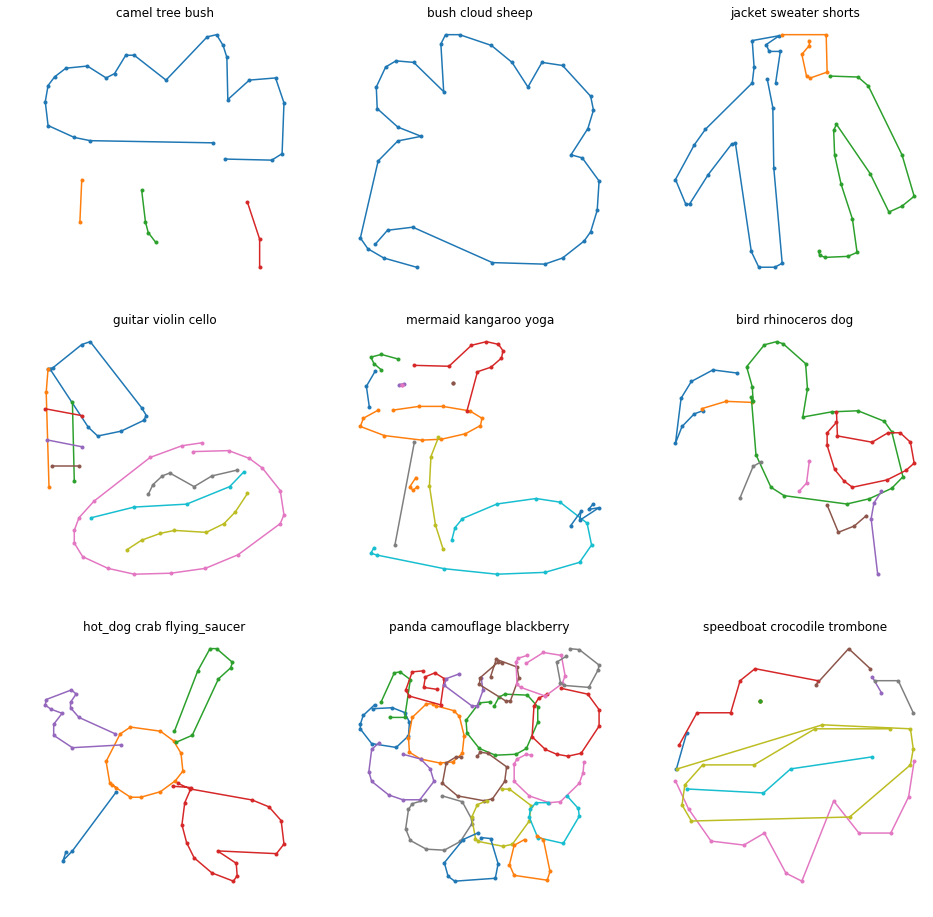

In [47]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(sub_drawing.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = sub_drawing[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(top_3_pred[c_id])